# Normalización con lemmatización y contador de palabras

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

# Cargar el modelo de SpaCy con lemmatización y desactivando NER
nlp = spacy.load('en_core_web_sm', disable=['ner'])

# Leer archivos CSV con Dask
def load_data_with_dask(file_paths):
    df = dd.read_csv(file_paths)
    return df

# Tokenización y lemmatización por lotes y paralelización
def lemmatize_abstracts_batch(texts, batch_size=1000, n_process=2):
    lemmas = []
    with ProgressBar():
        for doc in nlp.pipe(texts, batch_size=batch_size, n_process=n_process):
            lemmas.append([token.lemma_ for token in doc])
    return lemmas

# Función para procesar cada tema
def process_topic(file_paths, abstract_column='Abstract', batch_size=1000, n_process=2):
    df = load_data_with_dask(file_paths)
    texts = df[abstract_column].compute().tolist()
    lemmas = lemmatize_abstracts_batch(texts, batch_size=batch_size, n_process=n_process)
    
    # Crear un DataFrame con los lemas
    df_lemmas = pd.DataFrame({'Lemmas': [' '.join(lemma_list) for lemma_list in lemmas]})
    
    return df_lemmas

# Lista de archivos CSV para cada tema
topics = {
    'SustainableFinance': ['D:\CodeProjects\QuantFinanceResearch\GeneralCode\SustainableFinance_touse.csv'],
    'CorporateFinance': ['D:\CodeProjects\QuantFinanceResearch\GeneralCode\CorporateFinance_touse.csv'],
    'FinancialEngineering': ['D:\CodeProjects\QuantFinanceResearch\GeneralCode\FinancialEngineering_touse.csv'],
    'BehavioralFinance': ['D:\CodeProjects\QuantFinanceResearch\GeneralCode\BehavioralFinance_touse.csv'],
    'PortfolioOptimization': ['D:\CodeProjects\QuantFinanceResearch\GeneralCode\PortfolioOptimization_touse.csv'],
    'FinancialDerivatives': ['D:\CodeProjects\QuantFinanceResearch\GeneralCode\FinancialDerivatives_touse.csv'],
    'Financial_Risk_combined': ['D:\CodeProjects\QuantFinanceResearch\GeneralCode\FinancialRisk_touse.csv'],
    'AssetPricingModels': ['D:\CodeProjects\QuantFinanceResearch\GeneralCode\AssetPricingModels_touse.csv']
}

# Procesar todos los temas y almacenar los lemas en un DataFrame combinado
all_lemmas_df = pd.DataFrame()

for topic, file_paths in topics.items():
    print(f"Procesando tema: {topic}")
    df_lemmas = process_topic(file_paths)
    
    # Agregar los lemas al DataFrame combinado
    all_lemmas_df = pd.concat([all_lemmas_df, df_lemmas], ignore_index=True)

# Clase para encontrar palabras comunes en los lemas
class MostCommonWords:
    def __init__(self, df):
        self.df = df
    
    def find_most_common_words(self, n=1000):
        # Obtener los lemas como una lista de strings
        lemmas = self.df['Lemmas'].tolist()
        
        # Inicializar CountVectorizer
        vectorizer = CountVectorizer()
        
        # Ajustar y transformar los lemas
        X = vectorizer.fit_transform(lemmas)
        
        # Obtener el vocabulario del CountVectorizer
        vocabulary = vectorizer.get_feature_names_out()
        
        # Obtener las frecuencias de las palabras
        word_frequencies = zip(vocabulary, X.sum(axis=0).tolist()[0])
        
        # Ordenar las palabras por frecuencia
        sorted_words = sorted(word_frequencies, key=lambda x: x[1], reverse=True)
        
        # Obtener las palabras más comunes
        most_common_words = sorted_words[:n]
        
        return most_common_words

# Crear una instancia de la clase MostCommonWords
most_common_analyzer = MostCommonWords(all_lemmas_df)

# Encontrar las palabras más comunes
most_common_words = most_common_analyzer.find_most_common_words(n=1000)

# Imprimir las 1000 palabras más comunes
print("Las 1000 palabras más comunes son:")
for word, frequency in most_common_words:
    print(f"{word}: {frequency}")

# Guardar los resultados en un archivo CSV
df_palabras_comunes = pd.DataFrame(most_common_words, columns=['Palabra', 'Frecuencia'])
df_palabras_comunes.to_csv('palabras_comunes_tok.csv', index=False)


Procesando tema: SustainableFinance
Procesando tema: CorporateFinance
Procesando tema: FinancialEngineering
Procesando tema: BehavioralFinance
Procesando tema: PortfolioOptimization
Procesando tema: FinancialDerivatives
Procesando tema: Financial_Risk_combined
Procesando tema: AssetPricingModels
Las 1000 palabras más comunes son:
the: 1897585
of: 1212146
and: 1095022
be: 773585
to: 726242
in: 641811
for: 316711
risk: 273463
that: 255556
financial: 236281
on: 233860
this: 227530
with: 215239
as: 180854
have: 171125
by: 170493
use: 142501
we: 130662
model: 124581
study: 123263
an: 116352
from: 115449
market: 105106
result: 86586
it: 81208
or: 77623
which: 76356
their: 75317
can: 73725
base: 70442
paper: 67286
at: 66367
system: 65147
high: 64779
datum: 62636
these: 61670
analysis: 61418
not: 61364
more: 60621
management: 60102
research: 58927
between: 57671
method: 57324
factor: 55452
also: 53686
economic: 52812
all: 52692
increase: 52472
provide: 52390
well: 49637
development: 49332
appr

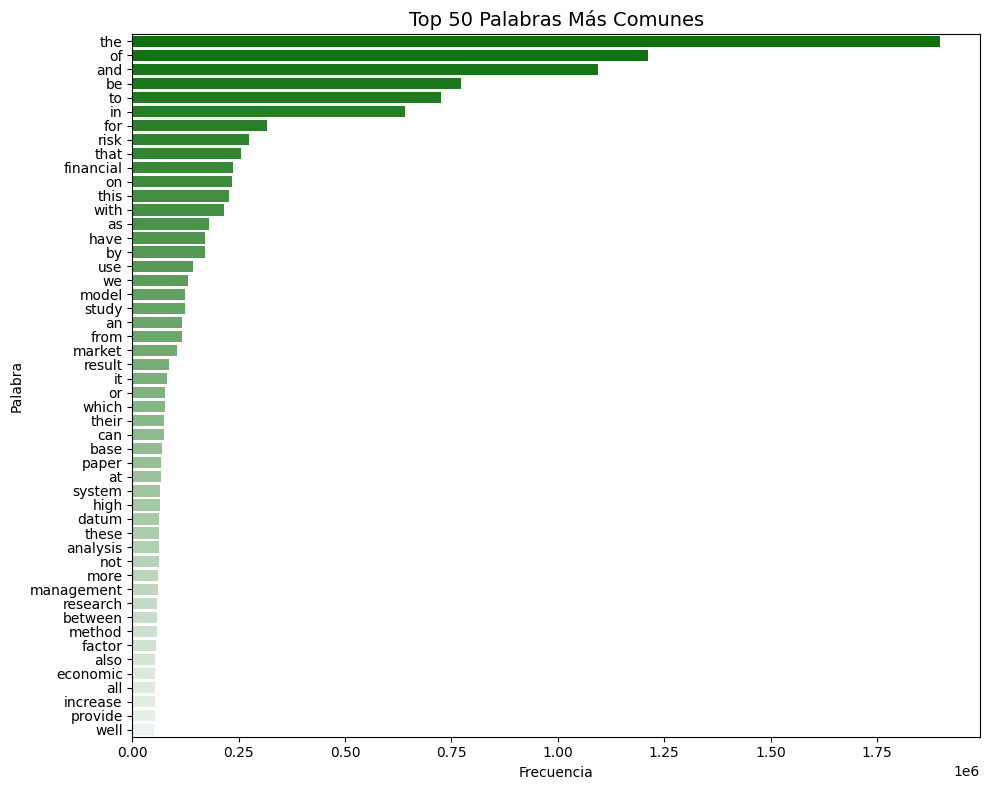

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el archivo CSV con las palabras más comunes
df_palabras_comunes = pd.read_csv('palabras_comunes_tok.csv')

# Filtrar las 50 palabras más comunes para mostrar en el gráfico (puedes cambiar el número según tus necesidades)
top_n_words = 50
df_top_palabras = df_palabras_comunes.head(top_n_words)

# Crear el gráfico de barras
plt.figure(figsize=(10, 8))
sns.barplot(x='Frecuencia', y='Palabra', data=df_top_palabras, palette='light:g_r')

# Configurar el título y las etiquetas del gráfico
plt.title(f'Top {top_n_words} Palabras Más Comunes', fontsize=14)
plt.xlabel('Frecuencia', fontsize=10)
plt.ylabel('Palabra', fontsize=10)

# Mostrar el gráfico
plt.tight_layout()
plt.show()
